In [14]:
%cd /content/drive/MyDrive/0.CV/0.plant_classification

/content/drive/MyDrive/0.CV/0.plant_classification


In [15]:
# !wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz -P pets
# !tar zxf pets/images.tar.gz -C pets

In [35]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz -P imagenette
!tar zxf imagenette/imagenette2-320.tgz -C imagenette
!gzip -d imagenette/imagenette2-320.tgz

--2022-08-06 08:17:47--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.238.109
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.238.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341663724 (326M) [application/x-tar]
Saving to: ‘imagenette/imagenette2-320.tgz’

imagenette2-320.tgz 100%[===================>] 325.83M  15.4MB/s    in 24s     

2022-08-06 08:18:11 (13.7 MB/s) - ‘imagenette/imagenette2-320.tgz’ saved [341663724/341663724]



## Importing Libraries

In [16]:
# !pip install --quiet optuna timm

In [17]:
import os
import re
import cv2
import sys
import glob
import random
import numpy as np
import pandas as pd
from pathlib import Path

import timm
import torch
import optuna
from optuna.trial import TrialState
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms

In [18]:
from pathlib import Path
from timm.data import ImageDataset
from torch.utils.data import DataLoader
from timm.data.parsers.parser import Parser
from timm.data.transforms_factory import create_transform 

# Update the DataLoader according to out dataset
class ParserImageName(Parser):
    def __init__(self, root, class_to_idx=None):
        super().__init__()

        self.root = Path(root)
        self.samples = list(self.root.glob("*.jpg"))

        if class_to_idx:
            self.class_to_idx = class_to_idx
        else:
            classes = sorted(
                set([self.__extract_label_from_path(p) for p in self.samples]),
                key=lambda s: s.lower(),
            )
            self.class_to_idx = {c: idx for idx, c in enumerate(classes)}

    def __extract_label_from_path(self, path):
        return "_".join(path.parts[-1].split("_")[0:-1])

    def __getitem__(self, index):
        path = self.samples[index]
        target = self.class_to_idx[self.__extract_label_from_path(path)]
        return open(path, "rb"), target

    def __len__(self):
        return len(self.samples)

    def _filename(self, index, basename=False, absolute=False):
        filename = self.samples[index][0]
        if basename:
            filename = filename.parts[-1]
        elif not absolute:
            filename = filename.absolute()
        return filename

In [30]:
import argparse
from pathlib import Path

import timm
import timm.data
import timm.loss
import timm.optim
import timm.utils
import torch
# import torchmetrics
from timm.scheduler import CosineLRScheduler

# from pytorch_accelerated.callbacks import SaveBestModelCallback
# from pytorch_accelerated.trainer import Trainer, DEFAULT_CALLBACKS

def create_datasets(image_size, data_mean, data_std, train_path, val_path):
    train_transforms = timm.data.create_transform(
        input_size=image_size,
        is_training=True,
        mean=data_mean,
        std=data_std,
        auto_augment="rand-m7-mstd0.5-inc1",
    )

    eval_transforms = timm.data.create_transform(
        input_size=image_size, mean=data_mean, std=data_std
    )

    train_dataset = timm.data.dataset.ImageDataset(
        train_path, transform=train_transforms
    )
    eval_dataset = timm.data.dataset.ImageDataset(val_path, transform=eval_transforms)

    return train_dataset, eval_dataset




In [61]:

# https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_simple.py
import timm
import inspect
import timm.optim


 # Set training arguments, hardcoded here for clarity
IMAGE_SIZE = (224, 224)


DEVICE = torch.device("cuda")
BATCHSIZE = [2, 4, 8, 16, 32]

data_path = Path('imagenette/imagenette2-320')
# dataset = ImageDataset(str(data_path), parser=ParserImageName(data_path))



DIR = os.getcwd()
EPOCHS = 10

data_path = Path(data_path)
TRAIN_PATH = data_path / "train"
VAL_PATH = data_path / "val"

smoothing = 0.1
mixup = 0.2
cutmix = 1.0

CLASSES = len(list(TRAIN_PATH.iterdir())) #len(dataset.parser.class_to_idx)

mixup_args = dict(
    mixup_alpha=mixup,
    cutmix_alpha=cutmix,
    label_smoothing=smoothing,
    num_classes=CLASSES,
)

N_TRAIN_EXAMPLES = 25000
N_VALID_EXAMPLES =  2500

 
EXPERIMENT_MODELS = [
                    # base models
                    "inception_v3" , "xception","densenet201",
                    #  base model improvements
                    "resnet200d_320", "resnext50_32x4d", "resnext101_32x8d",
                    # efficient net models
                    "efficientnet_b4","efficientnet_b3", 
                    #  Transformer models
                     "deit_base_patch16_384", "vit_large_patch16_384" ]

POOL_TYPES  = ['avg', 'max', 'avgmax', 'catavgmax']

EXPERIMENT_OPTIMIZERS = [cls_name for cls_name, cls_obj in inspect.getmembers(timm.optim) if inspect.isclass(cls_obj) if cls_name !='Lookahead']

def build_predictor(model_name: str, pretrained=True, num_classes=CLASSES, in_chans=3):
    try:
        # normal configuration. train all parameters.
        return timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes, in_chans=in_chans)
    except:
        raise ValueError(f"[ERROR] Unexpected value model_mode={model_name}")


def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    model_name = trial.suggest_categorical("model", EXPERIMENT_MODELS)
    pool_type = trial.suggest_categorical("pool_type", POOL_TYPES)
    # activation type ?
    model = build_predictor(model_name)
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []

    in_features = model.get_classifier().in_features
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)

        layers.append(nn.BatchNorm1d(in_features))
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        layers.append(nn.BatchNorm1d(out_features))

        p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)

        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, CLASSES))
    layers.append(nn.LogSoftmax(dim=1))
    model.fc =  nn.Sequential(*layers)
    return model


# def get_data():
#     # Load FashionMNIST dataset.

#     train_loader = torch.utils.data.DataLoader(
#         dataset[:N_TRAIN_EXAMPLES],
#         batch_size=BATCHSIZE,
#         shuffle=True,
#     )
#     valid_loader = torch.utils.data.DataLoader(
#         dataset[N_TRAIN_EXAMPLES:],
#         batch_size=BATCHSIZE,
#         shuffle=True,
#     )

#     return train_loader, valid_loader


def objective(trial):

    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", EXPERIMENT_OPTIMIZERS)
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    # optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    optimizer = timm.optim.create_optimizer_v2(model, opt=optimizer_name, lr=lr)

    # Get the FashionMNIST dataset.
    # train_loader, valid_loader = get_data()
    data_config = timm.data.resolve_data_config({}, model=model, verbose=True)
    data_mean = data_config["mean"]
    data_std = data_config["std"]

    # Create training and validation datasets
    train_dataset, eval_dataset = create_datasets(
        train_path=TRAIN_PATH,
        val_path=VAL_PATH,
        image_size=IMAGE_SIZE,
        data_mean=data_mean,
        data_std=data_std,
    )
    batch_size = trial.suggest_int("batch_size", 2, 32, step=2, log=False)

    train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,
        shuffle=True)
    valid_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=batch_size,
        shuffle=True)
    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * batch_size >= N_TRAIN_EXAMPLES:
                break

            data, target = data.to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                # Limiting validation data.
                if batch_idx * batch_size >= N_VALID_EXAMPLES:
                    break
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / min(len(valid_loader.dataset), N_VALID_EXAMPLES)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy


    

In [55]:

train_dataset, eval_dataset = create_datasets(
        train_path=TRAIN_PATH,
        val_path=VAL_PATH,
        image_size=IMAGE_SIZE,
        data_mean=(0.485, 0.456, 0.406),
        data_std=(0.229, 0.224, 0.225)
    )
batch_size = 4

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,
    shuffle=True)
valid_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=batch_size,
    shuffle=True)

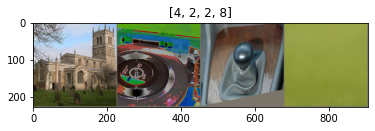

In [52]:
# Taken from timmdocs https://fastai.github.io/timmdocs/mixup_cutmix

import numpy as np
import matplotlib.pyplot as plt
import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

dataloader = iter(train_loader)
inputs, classes = next(dataloader)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[x.item() for x in classes])

In [62]:
study = optuna.create_study(study_name="image_classifier_selection", direction="maximize")
study.optimize(objective, n_trials=100, timeout=1200)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-08-06 09:17:02,447] A new study created in memory with name: image_classifier_selection
[I 2022-08-06 09:56:42,966] Trial 0 finished with value: 0.0896 and parameters: {'model': 'efficientnet_b4', 'pool_type': 'avg', 'n_layers': 2, 'n_units_l0': 121, 'dropout_l0': 0.40885336216956714, 'n_units_l1': 117, 'dropout_l1': 0.21991740972871646, 'optimizer': 'AdamP', 'lr': 0.0044894407262786205, 'batch_size': 24}. Best is trial 0 with value: 0.0896.


Study statistics: 
  Number of finished trials:  1
  Number of pruned trials:  0
  Number of complete trials:  1
Best trial:
  Value:  0.0896
  Params: 
    model: efficientnet_b4
    pool_type: avg
    n_layers: 2
    n_units_l0: 121
    dropout_l0: 0.40885336216956714
    n_units_l1: 117
    dropout_l1: 0.21991740972871646
    optimizer: AdamP
    lr: 0.0044894407262786205
    batch_size: 24
